# VAE

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
import random

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean


import os

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers

code1: https://www.tensorflow.org/tutorials/generative/cvae?hl=en

code2: https://keras.io/examples/generative/vae/


In [ ]:
# data processing
def preprocess_images(images):
  print(images.shape)
  images = images.reshape((images.shape[0], 170, 160, 3)) / 255
  x = []
  for image in images:
    image = resize(image, (64, 64)) # resize the image
    x.append(image)
  return x 

# load data
batch_data = np.load('VAE-input-new/collected_states_0.npy')
batch_data = batch_data.reshape(batch_data.shape[0], 170,160,3)

cut_off = int(len(batch_data)*0.7)

# preprocess data
train_images = preprocess_images(batch_data[0:128])
test_images = preprocess_images(batch_data[128:150])

(128, 170, 160, 3)
(22, 170, 160, 3)


## CVAE

In [ ]:
# Sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build the encoder
latent_dim = 64

encoder_inputs = keras.Input(shape=(64, 64, 3)) # input size
# layers.Conv2D(filters, kernel_size, strides=(1, 1), etc.)
# 32, 4
# 64, 4
# 128, 4
# 256, 4

x = layers.Conv2D(32, (31, 31), activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, (14, 14), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, (6, 6), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, (2, 2), activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation="relu")(x)

# latent representation
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   92288       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   401472      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     147520      conv2d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
# Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(1024, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 64))(x)
x = layers.Conv2DTranspose(64, (5, 5), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, (5, 5), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, (6, 6), activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, (6, 6), activation="sigmoid", strides=2, padding="same")(x)

#decoder_outputs = layers.Conv2DTranspose(64, 3, activation="sigmoid", padding="same")(x) # not sure about dimensionality here
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# architecture: https://arxiv.org/pdf/1507.08750.pdf

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              66560     
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 64)          102464    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 64)        102464    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 32)        73760     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 3)         3459

In [ ]:
# new try

# Build the encoder
latent_dim = 32

encoder_inputs = keras.Input(shape=(64, 64, 3)) # input size
# layers.Conv2D(filters, kernel_size, strides=(1, 1), etc.)
# 32, 4
# 64, 4
# 128, 4
# 256, 4
x = layers.Conv2D(32, (4, 4), activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, (4, 4), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, (4, 4), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, (4, 4), activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation="relu")(x)

# latent representation
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(1024, activation="relu")(latent_inputs)
x = layers.Reshape((2, 2, 256))(x)
x = layers.Conv2DTranspose(128, (5, 5), activation="relu", strides=(2, 2), padding="same")(x)
x = layers.Conv2DTranspose(128, (5, 5), activation="relu", strides=(2, 2), padding="same")(x)
x = layers.Conv2DTranspose(64, (5, 5), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, (6, 6), activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, (6, 6), activation="sigmoid", strides=2, padding="same")(x)

#decoder_outputs = layers.Conv2DTranspose(64, 3, activation="sigmoid", padding="same")(x) # not sure about dimensionality here
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 32)   1568        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 16, 16, 64)   32832       conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 8, 8, 128)    131200      conv2d_5[0][0]                   
____________________________________________________________________________________________

In [ ]:
# Create class model

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #self.mse_loss_tracker = keras.metrics.Mean(name="mse_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            # loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
            # losses: https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError
            #mse = tf.keras.losses.MeanSquaredError()
            #mse_loss = tf.reduce_sum(keras.losses.mse(data, reconstruction))

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss  #+ 0,1*mse_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        #self.mse_loss_tracker.update_state(mse_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            #"mse_loss": self.mse_loss_tracker.result(),
        }

## Training

In [ ]:
def preprocess_images(images):
  print(images.shape)
  images = images.reshape((images.shape[0], 170, 160, 3)) / 255
  # image_rescaled = rescale(image, 0.25, anti_aliasing=False)
  x = []
  for image in images:
    image = resize(image, (64, 64))
    x.append(image)
  return x 

# load data
batch_data = np.load('VAE-input-new/collected_states_3.npy')
batch_data = batch_data.reshape(batch_data.shape[0], 170,160,3)

In [ ]:
from keras.callbacks import History 
history = History()

######### RUN  0  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 3s 685ms/step - total_loss: 2837.4231 - reconstruction_loss: 2837.4141 - kl_loss: 0.0094
Epoch 2/5
3/3 [==============================] - 2s 689ms/step - total_loss: 2810.1736 - reconstruction_loss: 2810.0027 - kl_loss: 0.1707
Epoch 3/5
3/3 [==============================] - 2s 671ms/step - total_loss: 2702.5115 - reconstruction_loss: 2696.8621 - kl_loss: 5.6493
Epoch 4/5
3/3 [==============================] - 2s 688ms/step - total_loss: 2617.3962 - reconstruction_loss: 2614.5466 - kl_loss: 2.8499
Epoch 5/5
3/3 [==============================] - 2s 699ms/step - total_loss: 2573.9316 - reconstruction_loss: 2573.7295 - kl_loss: 0.2023


<Figure size 432x288 with 0 Axes>

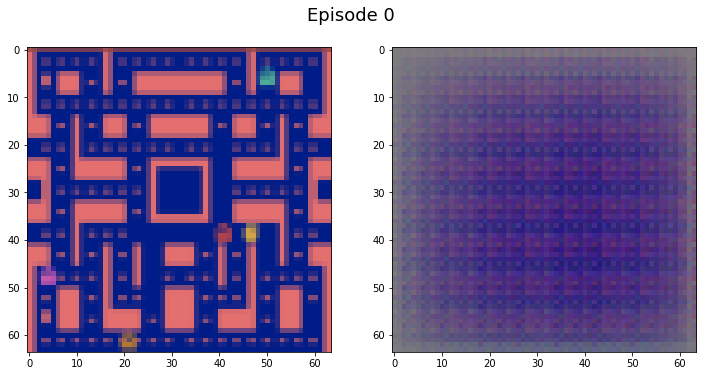

######### RUN  1  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 3s 739ms/step - total_loss: 2557.4099 - reconstruction_loss: 2557.3867 - kl_loss: 0.0232
Epoch 2/5
3/3 [==============================] - 2s 669ms/step - total_loss: 2540.9519 - reconstruction_loss: 2540.9485 - kl_loss: 0.0033
Epoch 3/5
3/3 [==============================] - 2s 690ms/step - total_loss: 2527.2896 - reconstruction_loss: 2527.2883 - kl_loss: 0.0012
Epoch 4/5
3/3 [==============================] - 2s 683ms/step - total_loss: 2512.2664 - reconstruction_loss: 2512.2654 - kl_loss: 8.2730e-04
Epoch 5/5
3/3 [==============================] - 2s 694ms/step - total_loss: 2495.2041 - reconstruction_loss: 2495.2036 - kl_loss: 6.8094e-04
######### RUN  2  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 692ms/step - total_loss: 2480.9861 - reconstruction_loss: 2480.9854 - kl_loss: 6.5570e-04
Epoch 2/5
3/3 [===========

<Figure size 432x288 with 0 Axes>

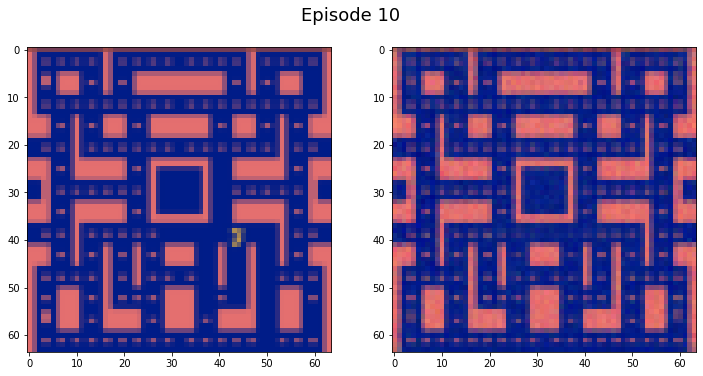

######### RUN  11  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 682ms/step - total_loss: 2042.1207 - reconstruction_loss: 2042.1172 - kl_loss: 0.0037
Epoch 2/5
3/3 [==============================] - 2s 697ms/step - total_loss: 2041.6686 - reconstruction_loss: 2041.6650 - kl_loss: 0.0036
Epoch 3/5
3/3 [==============================] - 2s 690ms/step - total_loss: 2040.3754 - reconstruction_loss: 2040.3717 - kl_loss: 0.0035
Epoch 4/5
3/3 [==============================] - 2s 693ms/step - total_loss: 2040.3164 - reconstruction_loss: 2040.3130 - kl_loss: 0.0033
Epoch 5/5
3/3 [==============================] - 2s 680ms/step - total_loss: 2042.4506 - reconstruction_loss: 2042.4476 - kl_loss: 0.0030
######### RUN  12  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 708ms/step - total_loss: 2040.0283 - reconstruction_loss: 2040.0254 - kl_loss: 0.0029
Epoch 2/5
3/3 [=====================

<Figure size 432x288 with 0 Axes>

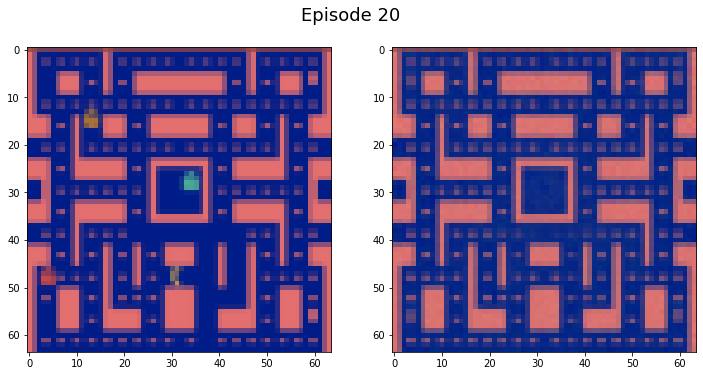

######### RUN  21  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 705ms/step - total_loss: 2033.7257 - reconstruction_loss: 2033.7245 - kl_loss: 0.0013
Epoch 2/5
3/3 [==============================] - 2s 696ms/step - total_loss: 2033.3529 - reconstruction_loss: 2033.3516 - kl_loss: 0.0013
Epoch 3/5
3/3 [==============================] - 2s 688ms/step - total_loss: 2033.3096 - reconstruction_loss: 2033.3082 - kl_loss: 0.0012
Epoch 4/5
3/3 [==============================] - 3s 767ms/step - total_loss: 2033.0121 - reconstruction_loss: 2033.0109 - kl_loss: 0.0012
Epoch 5/5
3/3 [==============================] - 2s 690ms/step - total_loss: 2034.2227 - reconstruction_loss: 2034.2213 - kl_loss: 0.0012
######### RUN  22  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 679ms/step - total_loss: 2034.7567 - reconstruction_loss: 2034.7554 - kl_loss: 0.0012
Epoch 2/5
3/3 [=====================

<Figure size 432x288 with 0 Axes>

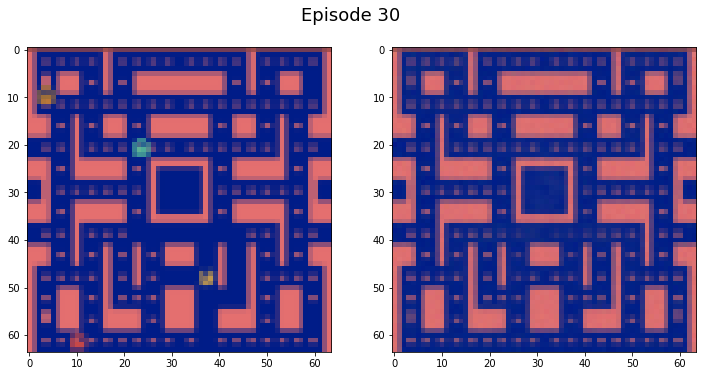

######### RUN  31  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 703ms/step - total_loss: 2031.2969 - reconstruction_loss: 2031.2963 - kl_loss: 7.0002e-04
Epoch 2/5
3/3 [==============================] - 2s 683ms/step - total_loss: 2031.4945 - reconstruction_loss: 2031.4938 - kl_loss: 6.8868e-04
Epoch 3/5
3/3 [==============================] - 2s 684ms/step - total_loss: 2031.8190 - reconstruction_loss: 2031.8184 - kl_loss: 6.7398e-04
Epoch 4/5
3/3 [==============================] - 2s 695ms/step - total_loss: 2030.9205 - reconstruction_loss: 2030.9200 - kl_loss: 6.6072e-04
Epoch 5/5
3/3 [==============================] - 2s 695ms/step - total_loss: 2032.7872 - reconstruction_loss: 2032.7866 - kl_loss: 6.5183e-04
######### RUN  32  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 684ms/step - total_loss: 2030.6396 - reconstruction_loss: 2030.6392 - kl_loss: 6.5347e-04
Epoch 2/5
3/

<Figure size 432x288 with 0 Axes>

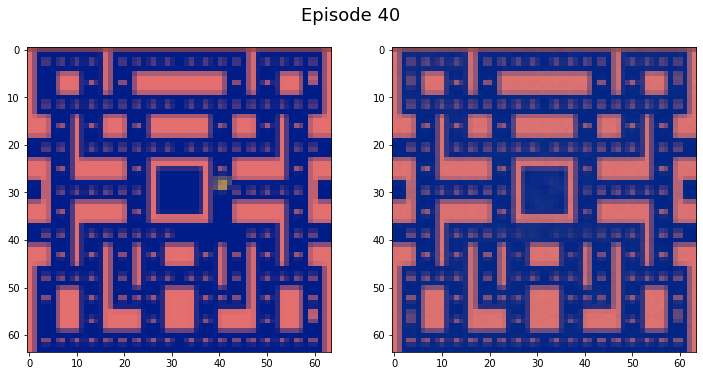

######### RUN  41  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 702ms/step - total_loss: 2030.2384 - reconstruction_loss: 2030.2379 - kl_loss: 6.6476e-04
Epoch 2/5
3/3 [==============================] - 2s 674ms/step - total_loss: 2030.1172 - reconstruction_loss: 2030.1163 - kl_loss: 6.7749e-04
Epoch 3/5
3/3 [==============================] - 2s 692ms/step - total_loss: 2030.5587 - reconstruction_loss: 2030.5580 - kl_loss: 6.9384e-04
Epoch 4/5
3/3 [==============================] - 2s 680ms/step - total_loss: 2030.5870 - reconstruction_loss: 2030.5863 - kl_loss: 7.0328e-04
Epoch 5/5
3/3 [==============================] - 2s 681ms/step - total_loss: 2030.1074 - reconstruction_loss: 2030.1068 - kl_loss: 7.1894e-04
######### RUN  42  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 671ms/step - total_loss: 2032.5221 - reconstruction_loss: 2032.5215 - kl_loss: 7.3236e-04
Epoch 2/5
3/

<Figure size 432x288 with 0 Axes>

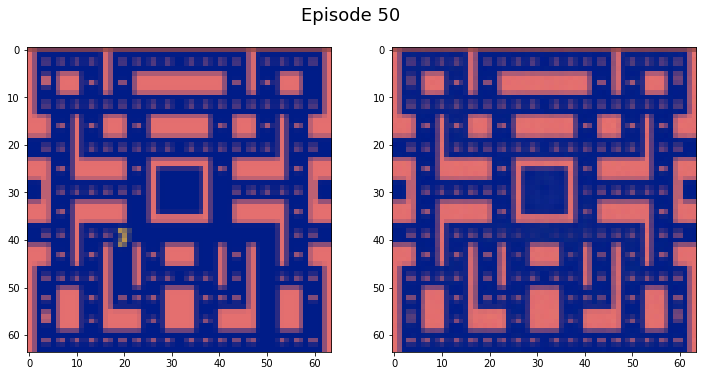

######### RUN  51  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 692ms/step - total_loss: 2029.7822 - reconstruction_loss: 2029.7806 - kl_loss: 0.0014
Epoch 2/5
3/3 [==============================] - 2s 672ms/step - total_loss: 2028.4467 - reconstruction_loss: 2028.4452 - kl_loss: 0.0015
Epoch 3/5
3/3 [==============================] - 2s 681ms/step - total_loss: 2028.8976 - reconstruction_loss: 2028.8961 - kl_loss: 0.0015
Epoch 4/5
3/3 [==============================] - 2s 690ms/step - total_loss: 2030.5480 - reconstruction_loss: 2030.5465 - kl_loss: 0.0015
Epoch 5/5
3/3 [==============================] - 2s 679ms/step - total_loss: 2029.3594 - reconstruction_loss: 2029.3579 - kl_loss: 0.0015
######### RUN  52  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 701ms/step - total_loss: 2029.4536 - reconstruction_loss: 2029.4521 - kl_loss: 0.0015
Epoch 2/5
3/3 [=====================

<Figure size 432x288 with 0 Axes>

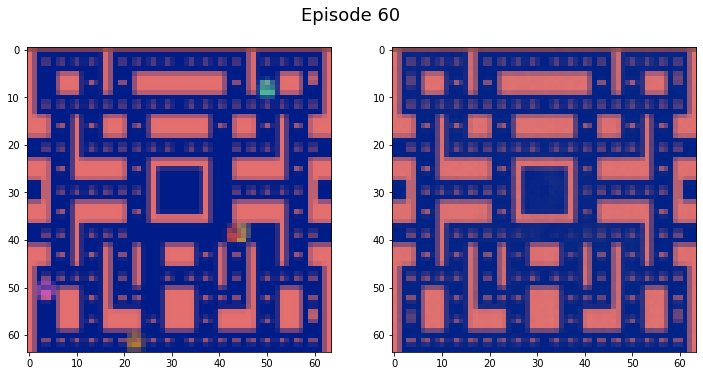

######### RUN  61  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 670ms/step - total_loss: 2028.5713 - reconstruction_loss: 2028.5685 - kl_loss: 0.0028
Epoch 2/5
3/3 [==============================] - 2s 690ms/step - total_loss: 2029.4098 - reconstruction_loss: 2029.4071 - kl_loss: 0.0029
Epoch 3/5
3/3 [==============================] - 2s 685ms/step - total_loss: 2029.5631 - reconstruction_loss: 2029.5602 - kl_loss: 0.0029
Epoch 4/5
3/3 [==============================] - 2s 682ms/step - total_loss: 2029.4352 - reconstruction_loss: 2029.4323 - kl_loss: 0.0030
Epoch 5/5
3/3 [==============================] - 2s 688ms/step - total_loss: 2029.5446 - reconstruction_loss: 2029.5415 - kl_loss: 0.0030
######### RUN  62  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 676ms/step - total_loss: 2029.7528 - reconstruction_loss: 2029.7496 - kl_loss: 0.0030
Epoch 2/5
3/3 [=====================

<Figure size 432x288 with 0 Axes>

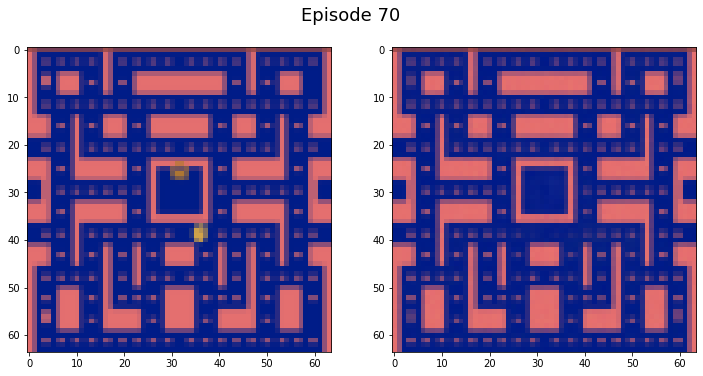

######### RUN  71  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 684ms/step - total_loss: 2028.1997 - reconstruction_loss: 2028.1952 - kl_loss: 0.0047
Epoch 2/5
3/3 [==============================] - 2s 684ms/step - total_loss: 2028.2660 - reconstruction_loss: 2028.2612 - kl_loss: 0.0047
Epoch 3/5
3/3 [==============================] - 2s 697ms/step - total_loss: 2026.6914 - reconstruction_loss: 2026.6866 - kl_loss: 0.0048
Epoch 4/5
3/3 [==============================] - 2s 706ms/step - total_loss: 2028.5233 - reconstruction_loss: 2028.5186 - kl_loss: 0.0048
Epoch 5/5
3/3 [==============================] - 2s 695ms/step - total_loss: 2027.1304 - reconstruction_loss: 2027.1255 - kl_loss: 0.0048
######### RUN  72  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 683ms/step - total_loss: 2028.2227 - reconstruction_loss: 2028.2178 - kl_loss: 0.0049
Epoch 2/5
3/3 [=====================

<Figure size 432x288 with 0 Axes>

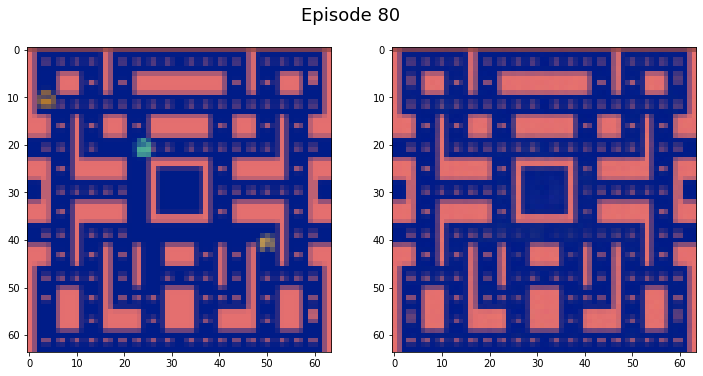

######### RUN  81  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 699ms/step - total_loss: 2028.2135 - reconstruction_loss: 2028.2072 - kl_loss: 0.0063
Epoch 2/5
3/3 [==============================] - 2s 680ms/step - total_loss: 2028.3110 - reconstruction_loss: 2028.3047 - kl_loss: 0.0064
Epoch 3/5
3/3 [==============================] - 2s 688ms/step - total_loss: 2028.0522 - reconstruction_loss: 2028.0459 - kl_loss: 0.0064
Epoch 4/5
3/3 [==============================] - 2s 681ms/step - total_loss: 2027.4310 - reconstruction_loss: 2027.4247 - kl_loss: 0.0064
Epoch 5/5
3/3 [==============================] - 2s 695ms/step - total_loss: 2027.9193 - reconstruction_loss: 2027.9127 - kl_loss: 0.0065
######### RUN  82  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 703ms/step - total_loss: 2027.9556 - reconstruction_loss: 2027.9491 - kl_loss: 0.0065
Epoch 2/5
3/3 [=====================

<Figure size 432x288 with 0 Axes>

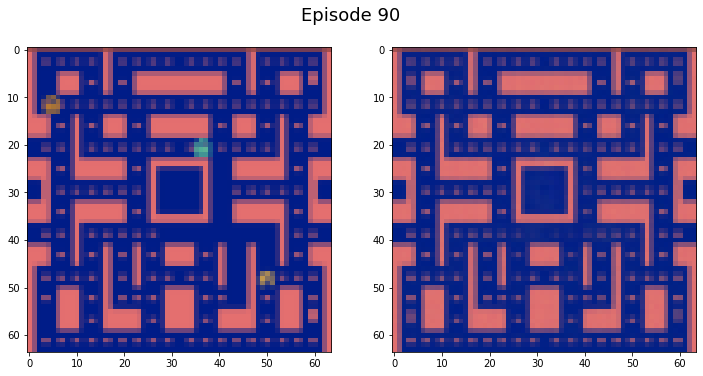

######### RUN  91  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 678ms/step - total_loss: 2028.5536 - reconstruction_loss: 2028.5459 - kl_loss: 0.0076
Epoch 2/5
3/3 [==============================] - 2s 701ms/step - total_loss: 2026.8076 - reconstruction_loss: 2026.8002 - kl_loss: 0.0076
Epoch 3/5
3/3 [==============================] - 2s 686ms/step - total_loss: 2027.8204 - reconstruction_loss: 2027.8129 - kl_loss: 0.0076
Epoch 4/5
3/3 [==============================] - 2s 687ms/step - total_loss: 2028.0856 - reconstruction_loss: 2028.0781 - kl_loss: 0.0076
Epoch 5/5
3/3 [==============================] - 2s 696ms/step - total_loss: 2027.9316 - reconstruction_loss: 2027.9240 - kl_loss: 0.0077
######### RUN  92  ###########
(128, 170, 160, 3)
(20, 170, 160, 3)
Epoch 1/5
3/3 [==============================] - 2s 707ms/step - total_loss: 2027.9061 - reconstruction_loss: 2027.8983 - kl_loss: 0.0077
Epoch 2/5
3/3 [=====================

In [ ]:
# probably want to rename the mnist into pacman_imgs
mnist_digits = np.concatenate([train_images, test_images], axis=0)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(lr=0.0005))
meta = []

#batch_data = np.load('VAE-input-new/collected_states_2.npy')
#batch_data = batch_data.reshape(batch_data.shape[0], 170,160,3)

for i in range(100):


    print('######### RUN ', i, ' ###########')
    # reload data to avoid memory overflow
    lower = random.randint(1, 1100)

    train_images = preprocess_images(batch_data[lower:lower+128])
    test_images = preprocess_images(batch_data[lower+130:lower+150])

    # probably want to rename the mnist into pacman_imgs
    mnist_digits = np.concatenate([train_images, test_images], axis=0)

    # train VAE
    history = vae.fit(mnist_digits, epochs=5, batch_size=64, shuffle=True)
    meta.append(history)

    # make use of VAE
    z_mean, z_log_var, z = vae.encoder.predict(np.array(train_images[90:91]))
    decoded_imgs = vae.decoder.predict(z)

    # plot results
    if i%10 == 0:
        plt.figure()
        fig, ax = plt.subplots(1,2, figsize=(12,10))
        ax[0].imshow(train_images[90])
        ax[1].imshow(decoded_imgs[0])
        fig.suptitle(f"Episode {i}", y=0.77, fontsize=18)
        plt.savefig(f"img-VAE/collected_states_{i}.pdf", bbox_inches='tight')
        plt.show()

# vae.save('')

In [ ]:
kl_loss = []
total_loss = []
reconstruction_loss = []

for i in range(100):
    kl_loss.append(sum(meta[i].history['kl_loss'])/5)
    total_loss.append(sum(meta[i].history['total_loss'])/5)
    reconstruction_loss.append(sum(meta[i].history['reconstruction_loss'])/5)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


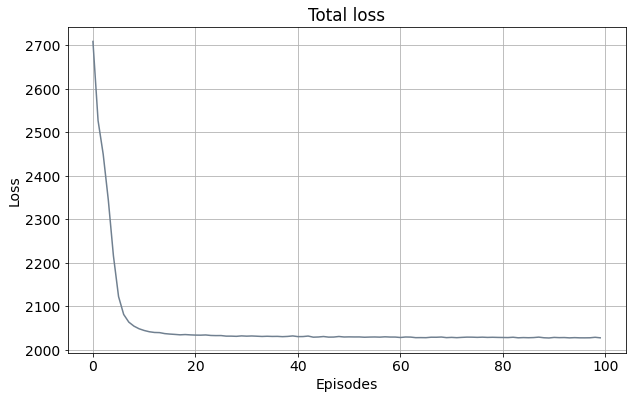

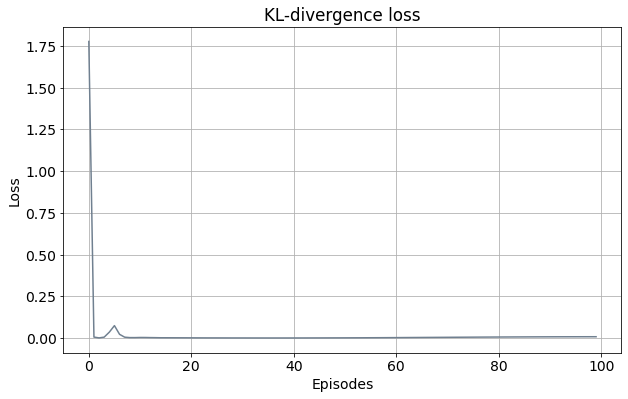

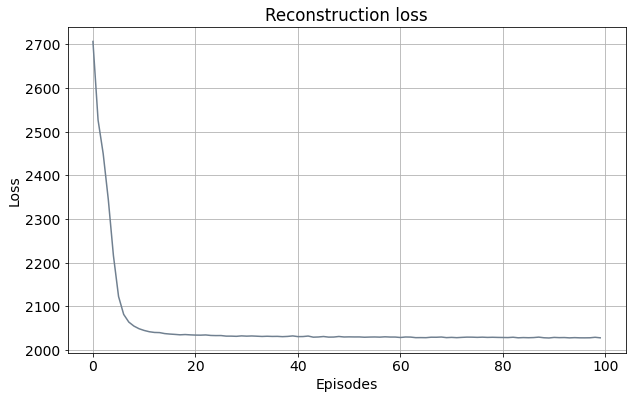

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)


plt.figure(figsize=(10, 6))
plt.plot(total_loss, color='slategray')
plt.title('Total loss')
plt.grid()
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.savefig('img-VAE/total_loss.pdf')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(kl_loss, color='slategray')
plt.title('KL-divergence loss')
plt.grid()
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.savefig('img-VAE/kl_loss.pdf')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(reconstruction_loss, color='slategray')
plt.title('Reconstruction loss')
plt.grid()
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.savefig('img-VAE/reconstruction_loss.pdf')
plt.show()

# plt.plot(vae.metrics[0])

In [ ]:
# save model: https://www.tensorflow.org/guide/keras/save_and_serialize

<Figure size 432x288 with 0 Axes>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


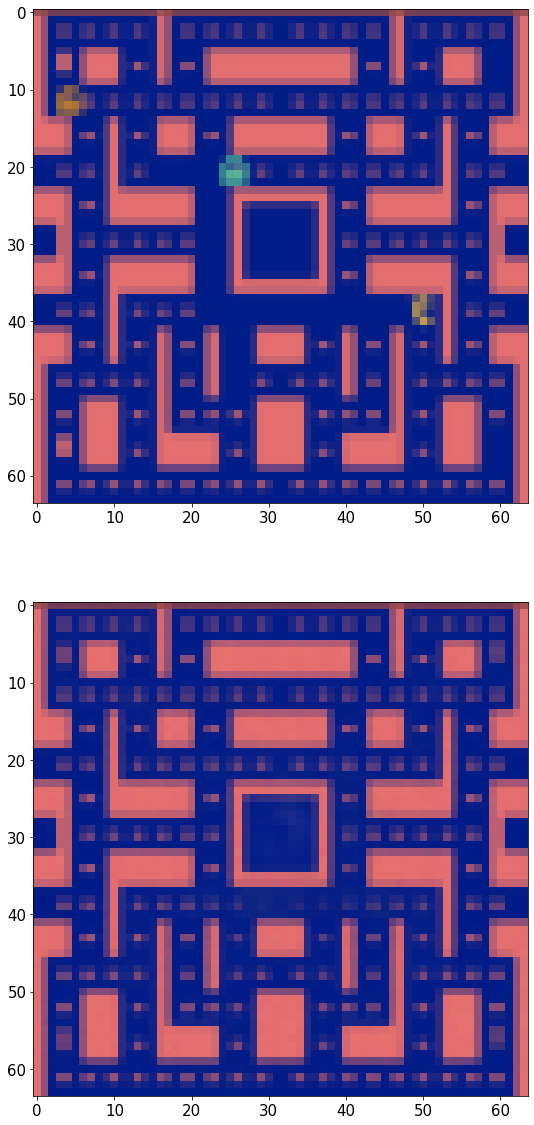

In [ ]:
# VAE at work
z_mean, z_log_var, z = vae.encoder.predict(np.array(train_images[90:91]))
decoded_imgs = vae.decoder.predict(z)


# display image reconstrution
plt.rcParams.update({'font.size': 15})

plt.figure()
fig, ax = plt.subplots(2,1, figsize=(25,20))
ax[0].imshow(train_images[90])
ax[1].imshow(decoded_imgs[0])

In [ ]:
# helpful:
# https://github.com/AppliedDataSciencePartners/WorldModels/blob/master/check_01_generate_data.ipynb
# https://github.com/AppliedDataSciencePartners/WorldModels/blob/master/vae/arch.py
# https://github.com/mickvanhulst/world_models/blob/master/train_rnn.py

<Figure size 432x288 with 0 Axes>

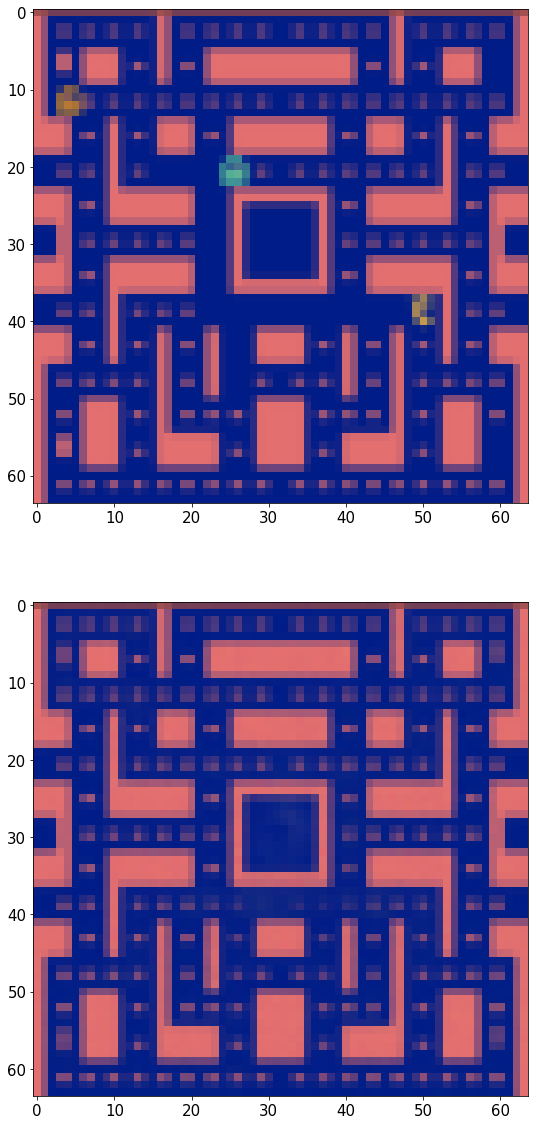

In [ ]:
# VAE at work
z_mean, z_log_var, z = vae.encoder.predict(np.array(train_images[90:91]))
decoded_imgs = vae.decoder.predict(z)


# display image reconstrution
plt.rcParams.update({'font.size': 15})

plt.figure()
fig, ax = plt.subplots(2,1, figsize=(25,20))
ax[0].imshow(train_images[90])
ax[1].imshow(decoded_imgs[0])

In [ ]:
# Generating images
# https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE

def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

  plot_latent_images(vae, 20)


In [ ]:
# plot the latent space

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)